In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import time

### Read Input dataset

In [9]:
play = pd.read_csv('/home/pv70249/LSH_DataSets/10kusers_5ksongs.csv', sep=',')
play.columns=['user','song','listen_count']

In [10]:
print ("Users-Songs: ", play['user'].count())
print ("Unique Users: ", play['user'].nunique())
print ("Unique Songs: ", play['song'].nunique())

Users-Songs:  1394964
Unique Users:  10000
Unique Songs:  5000


### Create Training and Testing Datasets

In [11]:
def split_data_train_test_random(self, train_proportion, test_proportion, random_state=42):
    df_train, df_test = train_test_split(self, train_size=train_proportion,
                                         test_size=test_proportion, random_state=42)
    return df_train, df_test


train_set,test_set = split_data_train_test_random(play,.8,.2)

In [12]:
print ( "Training:", "user-song pairs -", train_set['user'].count(), "unique users -", train_set['user'].nunique() ,"unique songs -", train_set['song'].nunique())
print ( "Testing :", "user-song pairs -", test_set['user'].count(), "unique users -", test_set['user'].nunique() ,"unique songs -", test_set['song'].nunique())

Training: user-song pairs - 1115971 unique users - 9999 unique songs - 5000
Testing : user-song pairs - 278993 unique users - 9985 unique songs - 5000


In [13]:
users = train_set['user'].unique()
songs = train_set['song'].unique()

songs_dict  = dict(zip(songs, range(len(songs))))
users_dict = dict(zip(users, range(len(users))))

data = np.zeros((train_set['user'].nunique(),train_set['song'].nunique()))
for index,row in train_set.iterrows():
    data[users_dict[row['user']], songs_dict[row['song']]] = row['listen_count']


### Baseline prediction count calculation

In [14]:
def baseline_prediction(df):
    baseline = df['listen_count'].mean()
    return baseline

baseline = baseline_prediction(train_set)
print (baseline)

2.2674451217818383


In [15]:
play_matrix = play.pivot(index='song', columns='user', values='listen_count')
play_matrix = play_matrix.fillna(0)
training_matrix = train_set.pivot(index='song', columns='user', values='listen_count')
training_matrix = training_matrix.fillna(0)


### The below Code create the hash functions, hash buckets and calculates similar items

In [16]:
def create_hash_functions(data, r):
    # Create Hash Functions
    # Inputs: (song,user) matrix; r - number of hash function for each band
    # Output = return the r hash functions
    
    rows,cols = data.shape
    hash_functions = np.random.standard_normal(size=(cols,r))
    return hash_functions

def create_hash_buckets(data, hash_functions, r):
    # Inputs: (song, user) matrix, the has functions created earlier
    # Ouput: Create a dictionary of hash values and the correponding matching song indices.
    # Generate a signature matrix from the hash functions and map it to the hash value to collect similar items
    
    hash_signatures = np.dot(data,hash_functions) >= 0    
    func_arr = 2 ** np.array(range(r -1 ,-1,-1))
    hash_value = np.dot(hash_signatures,func_arr)
    
    dict_hash = {}
    
    for i in range(len(hash_value)):
        if hash_value[i] not in dict_hash:
            dict_hash[hash_value[i]] = list()
        dict_hash[hash_value[i]].append(i)
        
    return dict_hash


def create_hash_tables(data, r, b):
    #Input: data - (song,user) matrix
    # r - number of hash functions in each band
    # b - number of hash buckets
    
    rows, cols = data.shape
    l_dict_hash = []
    l_hash_functions = []
    for i in range(b):
        h_functions = create_hash_functions(data, r)
        h_dict = create_hash_buckets(data, h_functions, r)
        l_dict_hash.append(h_dict)
        l_hash_functions.append(h_functions)
    return l_hash_functions, l_dict_hash


def similar_items(data, idx, l_hash_functions, l_dict_hash, r , b  ):
    # Input - index of the song
    # Output - list of songs and corresponding similarity distance metric for the given song
    # This returns the similar songs for a given song based on it's hash value.
    
    func_arr = 2 ** np.array(range(r -1 ,-1,-1))
    sim_items = set()
    for i in range(b):
        hash_signatures = np.dot(data[idx,:],l_hash_functions[i]) >= 0
        hash_val = np.dot(hash_signatures,func_arr)
        
        if hash_val in l_dict_hash[i]:
            sim_items.update(l_dict_hash[i][hash_val])

    sim_items.remove(idx)
    
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = cosine_similarity(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)))[:,0]
#     sims = pairwise_distances(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)), 'euclidean')[:,0]
#     sims = 1/(1+sims)    
    
    return list(zip(list(sim_items), sims))    

def all_similar_items(data, idx ):
    # Input - index of the song
    # data - song,user matrix
    # Output - list of songs and corresponding similarity distance metric for the given song
    # This returns the similar songs for a given song based on it's hash value.
    
    sim_items = set()
    for i in range(data.shape[0]):
        sim_items.update([i])

    sim_items.remove(idx)
#     print sim_items
    
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = cosine_similarity(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)))[:,0]
#     sims = pairwise_distances(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)), 'euclidean')[:,0]
#     sims = 1/(1+sims)    
    
    return list(zip(list(sim_items), sims))    

### Code to predict individual user-song listen count, Top N songs for a given user

In [17]:
def songs_sim_matrix_rb(songs_rb, data):
    # Inputs: Similarity metrics of list with a bunch of tuples; data of the shape (songs, users)
    # outout: Similarity matrix.
    
    sim_songs_matrix_rb = np.zeros((data.shape[0],data.shape[0]))
    
    for i in range(data.shape[0]):
        for j in range(len(songs_rb[i])):
            sim_songs_matrix_rb[i][songs_rb[i][j][0]] = songs_rb[i][j][1]
            
    return sim_songs_matrix_rb


def predict_individual(song_sim_matrix,data, user_idx, song_idx, baseline, K):
    # song similar matrix : item-item matrix with similarity measures
    # data : user,song matrix
    # user_idx : index of the user for prediction
    # song_idx : index of the song for prediction
    # returns prediction    
    user_items = data[user_idx].nonzero()[0]
    if len(user_items) == 0:
        return baseline
    
    neighbors = user_items[song_sim_matrix[song_idx, user_items].argsort()[::-1][0:K]]
    
    pred = (data[user_idx,neighbors].dot(song_sim_matrix[song_idx,neighbors])/sum(song_sim_matrix[song_idx,neighbors]))
    
    if np.isnan(pred):
        pred = baseline
    return pred

def predict_user_topNsongs(data,user_id,song_sim_matrix, K, N, users_dict,songs_dict,baseline, already_listened=False):
    # data - user,song matrix
    # User ID for prediction
    # song Similarity matrix
    # K - for neighbors
    # N - for prediction to the user.
    # users_dict = dictionary to convert user Id to index.
    # songs_dict - dictionary to convert sond id to index.
    
    n = song_sim_matrix.shape[0]
    
    try:
        user_idx = users_dict[user_id]
    except:
        raise "Application ERROR: User Not Found"         
    
    inverse_songs_dict = dict(zip(songs_dict.values(), songs_dict.keys()))
    listened_items = data[user_idx].nonzero()[0]
    
    temp = []
    for i in range(len(listened_items)):
        temp.append(listened_items[i])
    
    preds = {}
    listened = {}
    
    for j in range(n):
        preds[j] = predict_individual(song_sim_matrix,data,user_idx,j,baseline,K)
    
    for k in listened_items:
#         listened[k] = data[user_idx,k]
        listened[k] = preds[k]
        if not already_listened:
            del preds[k]
            
    sort_listened = sorted(listened.items(), key=lambda x: x[1], reverse = True)
    sort_pred = sorted(preds.items(), key=lambda x: x[1], reverse = True)

    top_recommendation = [inverse_songs_dict[i[0]] for i in sort_pred[:N]]
    top_listened = [inverse_songs_dict[i[0]] for i in sort_listened[:N]]
    
    
    df_pred = pd.DataFrame({ 'pred' : [sort_pred[i][1] for i in range(len(sort_pred))] ,
                            'song_id' : [inverse_songs_dict[i[0]] for i in sort_pred[:]], 
                            'song_idx' : [sort_pred[i][0] for i in range(len(sort_pred))] 
                           })

    df_listened = pd.DataFrame({ 'pred' : [sort_listened[i][1] for i in range(len(sort_listened))] ,
                            'song_id' : [inverse_songs_dict[i[0]] for i in sort_listened[:]], 
                            'song_idx' : [sort_listened[i][0] for i in range(len(sort_listened))] ,
                            'listen_count' : [data[user_idx,i[0]] for i in sort_listened[:]]
                           })

       
    return df_pred, df_listened, top_recommendation,  top_listened


def predict_user_topNsongs_coverage(data,user_id,song_sim_matrix, K, N, users_dict,songs_dict,baseline):
    # data - user,song matrix
    # User ID for prediction
    # song Similarity matrix
    # K - for neighbors
    # N - for prediction to the user.
    # users_dict = dictionary to convert user Id to index.
    # songs_dict - dictionary to convert sond id to index.
    
    n = song_sim_matrix.shape[0]
        
    
    user_idx = users_dict[user_id]
       
    listened_items = data[user_idx].nonzero()[0]
    inverse_songs_dict = dict(zip(songs_dict.values(), songs_dict.keys()))    
  
    preds = {}
    
    for j in range(n):
        preds[j] = predict_individual(song_sim_matrix,data,user_idx,j,baseline,K)
        
    for k in listened_items:
        del preds[k]           
               
    sort_pred = sorted(preds.items(), key=lambda x: x[1], reverse = True)

    top_recommendation = [inverse_songs_dict[i[0]] for i in sort_pred[:N]]
       
    return  top_recommendation
    


### The below code has the methods for RMSE, MAE, MSE and Coverage. Also it creates a grid search for hyper parameter optimization.

In [18]:
def mse(actual_arr, pred_arr):
    return np.average(np.power(actual_arr-pred_arr,2))

def rmse(actual_arr, pred_arr):
    return np.sqrt(np.average(np.power(actual_arr-pred_arr,2)))
  
def mae(actual_arr, pred_arr):
    return np.average(np.abs(actual_arr-pred_arr))

def create_similarity_matrix(data, r, b):
    # Input - data is user,song matrix
    l_hash, l_dict = create_hash_tables(data.T, r,b)
    start_time = time.time()
    sim_songs = []
    for i in range(len(data.T)):
        sim_songs.append(similar_items(data.T, i, l_hash, l_dict, r , b  ))
    end_time = time.time()
    time_diff = end_time-start_time
    sim_song_matrix = songs_sim_matrix_rb(sim_songs, data.T)
    
    return sim_song_matrix, time_diff

def create_icf_similarity_matrix(data):
    # Input - data is user,song matrix
    start_time = time.time()
    sim_songs = []
    for i in range(len(data.T)):
        sim_songs.append(all_similar_items(data.T, i ))
    end_time = time.time()
    time_diff = end_time-start_time
    sim_song_matrix = songs_sim_matrix_rb(sim_songs, data.T)
    
    return sim_song_matrix, time_diff

def coverage(sim_song_matrix,data_set1,K, N):
    
    data_set = data_set1.reset_index(drop = True)
    
    l_users = data_set['user'].unique()
    l_songs = data_set['song'].unique()
    
    l_songs_dict  = dict(zip(l_songs, range(len(l_songs))))
    l_users_dict = dict(zip(l_users, range(len(l_users))))
    
    l_out = {}
    l_in = {}
    cov = 0
    items = 0
    l_items = 0
    l_cov = 0
    
    start_time = time.time()
    for x in range(len(l_users)):
        try:
             cv_user_idx = users_dict[l_users[x]]
        except:
            continue            
        l_out[x] = predict_user_topNsongs_coverage(data,l_users[x],sim_song_matrix, K, N, users_dict,songs_dict,baseline)

#     The below approach is commented out as it's taking longer than the other approach

#     start_time = time.time()
#     for i in range(len(data_set)):
#         try :
#             cv_user_idx = users_dict[data_set.iloc[i]['user']]
#         except:
#             continue        
#         l_items += 1
#         if l_users_dict[data_set.iloc[i]['user']] not in l_in:
#             l_in[l_users_dict[data_set.iloc[i]['user']]] = list()
#         l_in[l_users_dict[data_set.iloc[i]['user']]].append(data_set.iloc[i]['song'])
# #     print ('length l_in', len(l_in))
# #     print ('length l_out', len(l_out))
#     for j in range(len(l_users)):
#         try :
#             cv_user_idx = users_dict[l_users[j]]
#         except:
#             continue        
#         l_cov += len(set(l_in[j]).intersection(l_out[j]))
#     l_top_cov = (l_cov/l_items)*100
#     end_time = time.time()
#     time_diff = end_time-start_time
#     print ('l_cov',l_cov,'l_items',l_items,'l_coverage',l_top_cov,'time',time_diff)

    
    
    for i in range(len(data_set)):
        ## Ingnore if  user or song doesn't exist in users_dict and song_dict
        try:
            cv_user_idx = users_dict[data_set.iloc[i]['user']]
        except:
            continue        
        try:
            cv_song_idx = songs_dict[data_set.iloc[i]['song']]
        except:
            continue
        a = [data_set.iloc[i]['song']]
        b = l_out[l_users_dict[data_set.iloc[i]['user']]]
        cov += len(set(a).intersection(b))
        items += 1     
   
    top_cov = (cov/items)*100
    end_time = time.time()
    time_diff = end_time-start_time
    print ('cov',cov,'items',items,'coverage','total items',len(data_set),'users in test data', len(l_users) ,'users also in train', len(l_out) ,
           'coverage percent', top_cov,'time',time_diff,)    
    
    return top_cov

def predict_func(sim_song_matrix, data_set, baseline, k):
    predict = []
    actual = []
    start_time = time.time()

    
    for x in range(len(data_set)):
        ## Ingnore if  user or song doesn't exist in users_dict and song_dict
        try:
            gs_user_idx = users_dict[data_set.iloc[x]['user']]
        except:
            continue        
        try:
            gs_song_idx = songs_dict[data_set.iloc[x]['song']]
        except:
            continue             
        predict.append(predict_individual(sim_song_matrix,data, gs_user_idx, gs_song_idx, baseline, k))
        actual.append(data_set.iloc[x]['listen_count'])
        
    end_time = time.time()
    time_diff = end_time-start_time
    f_rmse = rmse(np.array(actual),np.array(predict))
    f_mae = mae(np.array(actual),np.array(predict))
    f_mse = mse(np.array(actual),np.array(predict))
    
    return f_rmse, f_mae, f_mse, time_diff

#### Grid Search
def lsh_grid_search(r_list, b_list, k_list):
    lsh_gs_df = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov',  'top20_cov','top40_cov','top60_cov'])
    for r in r_list:
        for b in b_list:
            print ('running lsh_grid_search: similarity matrix creation...',r,b, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
            lsh_sim_song_matrix, time_diff_mat_creation = create_similarity_matrix(data,r,b)
            for k in k_list:
                print ('running lsh_grid_search: test data prediction...',r,b,k, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                gs_rmse,gs_mae,gs_mse,time_diff_pred = predict_func(lsh_sim_song_matrix, test_set, baseline,k)
                
                print ('running lsh coverage: test data coverage with topN-10...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top10_cov = 10
                print ('running lsh  coverage: test data coverage with topN-20...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top20_cov = coverage(lsh_sim_song_matrix,test_set,k, 20)
                print ('running lsh  coverage: test data coverage with topN-40...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top40_cov = coverage(lsh_sim_song_matrix,test_set,k, 40)
                print ('running lsh  coverage: test data coverage with topN-60...',r,b,k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
                top60_cov = coverage(lsh_sim_song_matrix,test_set,k, 60)
                
                lsh_gs_df = lsh_gs_df.append({'Model':'LSH', 'R':r, 'B':b, 'K':k, 'Time':time_diff_mat_creation, 'Predict_Time':time_diff_pred,'RMSE':gs_rmse,
                            'MAE':gs_mae,'MSE':gs_mse,'Describe':'LSH;R:'+str(r)+';B:'+str(b),'Describe_k':'LSH;R:'+str(r)+';B:'+str(b)+';K:'+str(k),
                            'top10_cov':top10_cov, 'top20_cov':top20_cov, 'top40_cov':top40_cov, 'top60_cov':top60_cov}, ignore_index=True)    
    return lsh_gs_df

def icf_grid_search(k_list):
    icf_gs_df = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])
    print ('running icf_grid_search: similarity matrix creation...', ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    icf_sim_song_matrix, time_diff_mat_creation = create_icf_similarity_matrix(data)
    for k in k_list:
        print ('running icf_grid_search: test data prediction...',k, ';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        gs_rmse,gs_mae,gs_mse,time_diff_pred = predict_func(icf_sim_song_matrix, test_set, baseline,k)
        
        print ('running icf coverage: test data coverage with topN-10...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top10_cov = 10
        print ('running icf coverage: test data coverage with topN-20...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top20_cov = coverage(icf_sim_song_matrix,test_set,k, 20)
        print ('running icf coverage: test data coverage with topN-40...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top40_cov = coverage(icf_sim_song_matrix,test_set,k, 40)
        print ('running icf coverage: test data coverage with topN-60...',k,';Start Time:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
        top60_cov = coverage(icf_sim_song_matrix,test_set,k, 60)

        icf_gs_df = icf_gs_df.append({'Model':'ItemCF', 'R':'', 'B':'', 'K':k, 'Time':time_diff_mat_creation, 'Predict_Time':time_diff_pred,'RMSE':gs_rmse,
                            'MAE':gs_mae,'MSE':gs_mse,'Describe':'ItemCF','Describe_k':'ItemCF'+';K:'+str(k),
                            'top10_cov':top10_cov, 'top20_cov':top20_cov, 'top40_cov':top40_cov, 'top60_cov':top60_cov}, ignore_index=True)    
                
                
    return icf_gs_df

gs = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])

lsh_r_list = [2,3,4]
lsh_b_list = [3,4]
lsh_k_list = [20]


gs_lsh_grid_search = lsh_grid_search(lsh_r_list,lsh_b_list, lsh_k_list)
gs_icf_grid_search = icf_grid_search(lsh_k_list)

gs = gs.append(gs_lsh_grid_search,ignore_index=True)
gs = gs.append(gs_icf_grid_search,ignore_index=True)

            
with pd.option_context('expand_frame_repr', False):
    print (gs)
    

running lsh_grid_search: similarity matrix creation... 2 3 ;Start Time: 2018-12-14 18:23:03
running lsh_grid_search: test data prediction... 2 3 20 ;Start Time: 2018-12-14 19:12:39


/opt/anaconda/anaconda3/envs/ts_demo/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


running lsh coverage: test data coverage with topN-10... 2 3 20 ;Start Time: 2018-12-14 19:16:29
running lsh  coverage: test data coverage with topN-20... 2 3 20 ;Start Time: 2018-12-14 19:16:29
cov 5165 items 278992 coverage total items 278993 users in test data 9985 users also in train 9984 coverage percent 1.8513075643746058 time 3759.1378729343414
running lsh  coverage: test data coverage with topN-40... 2 3 20 ;Start Time: 2018-12-14 20:19:08
cov 8818 items 278992 coverage total items 278993 users in test data 9985 users also in train 9984 coverage percent 3.1606641050639444 time 3767.272619009018
running lsh  coverage: test data coverage with topN-60... 2 3 20 ;Start Time: 2018-12-14 21:21:55
cov 11884 items 278992 coverage total items 278993 users in test data 9985 users also in train 9984 coverage percent 4.259620347536846 time 3788.359791278839
running lsh_grid_search: similarity matrix creation... 2 4 ;Start Time: 2018-12-14 22:25:04
running lsh_grid_search: test data predict

In [19]:
pd.set_option('display.max_rows', 500)
gs[['Model','R','B','K','Time','RMSE','MAE','MSE','Describe_k','top10_cov','top20_cov','top40_cov','top60_cov']]

,Model,R,B,K,Time,RMSE,MAE,MSE,Describe_k,top10_cov,top20_cov,top40_cov,top60_cov
0,LSH,2,3,20,2967.499461,3.189010,1.434701,10.169784,LSH;R:2;B:3;K:20,10,1.851308,3.160664,4.259620
1,LSH,2,4,20,4334.493922,3.165142,1.427074,10.018121,LSH;R:2;B:4;K:20,10,1.954178,3.298661,4.429876
2,LSH,3,3,20,2394.083391,3.226849,1.447648,10.412556,LSH;R:3;B:3;K:20,10,1.418320,2.522295,3.486480
3,LSH,3,4,20,2743.578066,3.200073,1.440491,10.240469,LSH;R:3;B:4;K:20,10,1.648434,2.850978,3.907639
4,LSH,4,3,20,1325.892756,3.303475,1.470664,10.912944,LSH;R:4;B:3;K:20,10,0.964544,1.772094,2.555629
5,LSH,4,4,20,1640.020324,3.279678,1.453818,10.756285,LSH;R:4;B:4;K:20,10,1.101824,1.977118,2.821945
6,ItemCF,,,20,5908.923053,3.150446,1.423779,9.925310,ItemCF;K:20,10,2.285012,3.769284,4.996559


In [20]:
test = pd.DataFrame(columns=['Model','R','B','K','Time','Predict_Time','RMSE','MAE','MSE','Describe','Describe_k','top10_cov', 'top20_cov','top40_cov','top60_cov'])
test = test.append(gs, ignore_index=True)
test.replace('',0, inplace=True)
test1 = test[test['B'].values < 5]
test2 = test1[test1['K'].values==20].sort_values('Time')

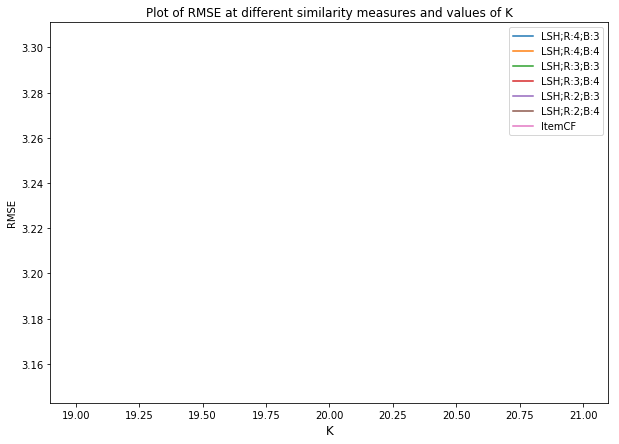

In [21]:
plt.figure(figsize=(10,7))
for val in set(test['Describe'].values):
    sv = plt.plot(test1[test1['Describe']==val]['K'],test1[test1['Describe']==val]['RMSE'])
plt.xlabel('K', fontsize=12)
plt.ylabel('RMSE')
plt.title('Plot of RMSE at different similarity measures and values of K')
plt.legend(test2['Describe'].values, loc='upper right',  fancybox = True)
# fig = sv.get_figure()
plt.savefig('5krmse_k')
plt.show()

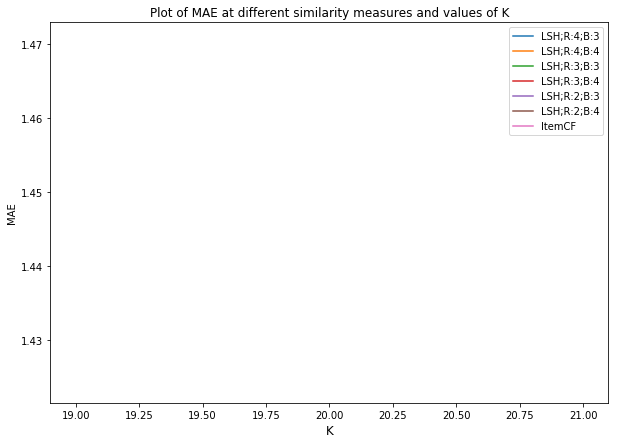

In [22]:
plt.figure(figsize=(10,7))
for val in set(test1['Describe'].values):
    plt.plot(test1[test1['Describe']==val]['K'],test1[test1['Describe']==val]['MAE'])
plt.xlabel('K', fontsize=12)
plt.ylabel('MAE')
plt.title('Plot of MAE at different similarity measures and values of K')
plt.legend(test2['Describe'].values, loc='upper right',  fancybox = True)
plt.savefig('5kmae_k')
plt.show()

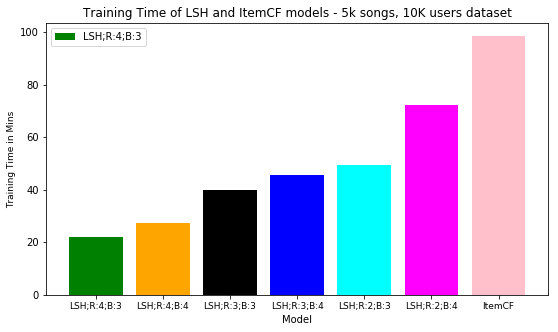

In [40]:
plt.figure(figsize=(9,5))
index = np.arange(len(test2['Describe'].values))
plt.bar(index,test2['Time'].values/60,color=['green', 'orange', 'black', 'blue', 'cyan', 'magenta','pink','yellow','red'])
plt.xlabel('Model')
plt.ylabel('Training Time in Mins',fontsize=9)
plt.xticks(index,test2['Describe'].values,fontsize=9)
plt.title('Training Time of LSH and ItemCF models - 5k songs, 10K users dataset')
plt.legend(test2['Describe'].values, loc="upper left")
plt.savefig('5ktimes')
plt.show()

### Comparing the prediction with actual listens

In [24]:
song_info = pd.read_csv('/home/pv70249/LSH_DataSets/song_info.csv')[['song_id', 'artist_name', 'track_name']]

In [25]:
def listen(row):
    if row[['listen_count']].isnull().any():
        return 'N'
    else :
        return 'Y'

def user_prediction(sim_song_matrix,K,N):
    # Outputs
    # pred_out - Predictions including listened songs
    # pred_out_listened - Predictions excluding listened songs
    # listened - only listened songs ordered by listen count
    
    #This is for included listened songs also in prediction
    u_df_pred, u_df_listened, u_top_recommendation,  u_top_listened = predict_user_topNsongs(data,
                                                         '6a944bfe30ae8d6b873139e8305ae131f1607d5f',
                                                          sim_song_matrix, K, N, users_dict, songs_dict,
                                                          baseline, True )
    u_pred = pd.merge(u_df_pred[['song_id', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    u_pred_out = pd.merge(u_pred,u_df_listened[['song_id','listen_count']],how ='left',on='song_id').reset_index(drop=True)
    u_pred_out['listened'] = u_pred_out.apply(lambda row: listen(row),axis=1)
    
    
    #This is for only non-listened songs
    df_pred1, df_listened1, top_recommendation1,  top_listened1 = predict_user_topNsongs(data,
                                                         '6a944bfe30ae8d6b873139e8305ae131f1607d5f',
                                                          sim_song_matrix, K, N, users_dict, songs_dict,
                                                          baseline, False )
    
    pred1 = pd.merge(df_pred1[['song_id', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    pred_out1 = pd.merge(pred1,df_listened1[['song_id','listen_count']],how ='left',on='song_id').reset_index(drop=True)
    pred_out1['listened'] = pred_out1.apply(lambda row: listen(row),axis=1)
    
    listened = pd.merge(u_df_listened[['song_id', 'listen_count', 'pred']], song_info, how='inner', on='song_id').reset_index(drop=True)
    listened = listened.sort_values('listen_count',ascending = False)
    
    return u_pred_out,pred_out1, listened

In [26]:
print ('lsh matrix')
lsh_sim_song_matrix_24, time_diff_mat_creation_24 = create_similarity_matrix(data,2,4)
print ('icf matrix')
icf_sim_song_matrix, time_diff_mat_creation = create_icf_similarity_matrix(data)

lsh_pred_out,lsh_pred_out_listened, lsh_listened = user_prediction(lsh_sim_song_matrix_24,20,60)
icf_pred_out,icf_pred_out_listened, icf_listened = user_prediction(icf_sim_song_matrix,20,60)

lsh matrix
icf matrix


In [38]:
lsh_pred_out[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOFPNOY12A8C134D40,174.738188,George Younce,This Old House w/ When The Saints Medley,NaN,N
1,SOWMDQL12A8C13FB54,71.810742,Daughtry featuring Slash,What I Want,NaN,N
2,SOBBZPM12AB017DF4B,54.122476,Radiohead,Pop Is Dead,NaN,N
3,SOAOOWF12A8C1347EC,43.382701,Harry Gregson-Williams,Bullet Tells The Truth,NaN,N
4,SOVPAJA12A58A77B15,42.751578,Amos Lee,Kid,NaN,N
5,SOKHHXJ12AF72A5325,41.768872,Jack Johnson,People Watching,NaN,N
6,SOKANYX12A8C13A252,37.336394,OneRepublic,Say (All I Need),24.0,Y
7,SOYHEPA12A8C13097F,37.211790,Jack Johnson,Moonshine,NaN,N
8,SOEIBBE12A58A7C909,36.971608,Björk,Army of Me,NaN,N
9,SOJEYPO12AAA8C6B0E,36.046911,Paramore,Ignorance (Album Version),23.0,Y


In [28]:
lsh_pred_out_listened[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOFPNOY12A8C134D40,174.738188,George Younce,This Old House w/ When The Saints Medley,NaN,N
1,SOWMDQL12A8C13FB54,71.810742,Daughtry featuring Slash,What I Want,NaN,N
2,SOBBZPM12AB017DF4B,54.122476,Radiohead,Pop Is Dead,NaN,N
3,SOAOOWF12A8C1347EC,43.382701,Harry Gregson-Williams,Bullet Tells The Truth,NaN,N
4,SOVPAJA12A58A77B15,42.751578,Amos Lee,Kid,NaN,N
5,SOKHHXJ12AF72A5325,41.768872,Jack Johnson,People Watching,NaN,N
6,SOYHEPA12A8C13097F,37.211790,Jack Johnson,Moonshine,NaN,N
7,SOEIBBE12A58A7C909,36.971608,Björk,Army of Me,NaN,N
8,SOFQMHG12A6701E781,32.446568,Nick Cave & The Bad Seeds,Red Right Hand,NaN,N
9,SOAGWPY12AB018CD74,29.909032,Iration,Time Bomb,NaN,N


In [29]:
lsh_listened[:20]

,song_id,listen_count,pred,artist_name,track_name
6,SOBONKR12A58A7A7E0,271.0,16.980344,Dwight Yoakam,You're The One
46,SOAUWYT12A81C206F1,78.0,7.120722,Björk,Undo
4,SOUPVZJ12A6701D985,44.0,32.812907,D-12,Purple Pills
5,SOBJSLW12A6D4F9158,43.0,23.358279,Ryan Adams,Wonderwall
42,SOUVTSM12AC468F6A7,32.0,7.784874,Lil Wayne / Eminem,Drop The World
56,SOFGJCW12AF72A812D,31.0,5.221917,Kelly Clarkson,Already Gone
3,SOLRBSH12AB018AE7B,27.0,34.761700,Colbie Caillat,I Never Told You
0,SOKANYX12A8C13A252,24.0,37.336394,OneRepublic,Say (All I Need)
1,SOJEYPO12AAA8C6B0E,23.0,36.046911,Paramore,Ignorance (Album Version)
66,SOXQROF12AB0186B1D,17.0,3.874521,Lily Allen,The Fear


In [39]:
icf_pred_out[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOFPNOY12A8C134D40,153.534718,George Younce,This Old House w/ When The Saints Medley,NaN,N
1,SOWMDQL12A8C13FB54,61.018263,Daughtry featuring Slash,What I Want,NaN,N
2,SOBBZPM12AB017DF4B,52.145812,Radiohead,Pop Is Dead,NaN,N
3,SOYABSZ12A81C1FEAC,43.228155,Reality Check,Masquerade (Reality Check Album Version),NaN,N
4,SOLXFNR12A8C1313FD,42.948650,The Hives,Bigger Hole To Fill,NaN,N
5,SOJEYPO12AAA8C6B0E,38.157234,Paramore,Ignorance (Album Version),23.0,Y
6,SOKANYX12A8C13A252,37.396986,OneRepublic,Say (All I Need),24.0,Y
7,SOSYZTA12AB0185B04,37.276538,Cutting Crew,(I Just) Died In Your Arms,16.0,Y
8,SOVPAJA12A58A77B15,36.811209,Amos Lee,Kid,NaN,N
9,SOLRBSH12AB018AE7B,36.304167,Colbie Caillat,I Never Told You,27.0,Y


In [31]:
icf_pred_out_listened[:20]

,song_id,pred,artist_name,track_name,listen_count,listened
0,SOFPNOY12A8C134D40,153.534718,George Younce,This Old House w/ When The Saints Medley,NaN,N
1,SOWMDQL12A8C13FB54,61.018263,Daughtry featuring Slash,What I Want,NaN,N
2,SOBBZPM12AB017DF4B,52.145812,Radiohead,Pop Is Dead,NaN,N
3,SOYABSZ12A81C1FEAC,43.228155,Reality Check,Masquerade (Reality Check Album Version),NaN,N
4,SOLXFNR12A8C1313FD,42.948650,The Hives,Bigger Hole To Fill,NaN,N
5,SOVPAJA12A58A77B15,36.811209,Amos Lee,Kid,NaN,N
6,SOYHEPA12A8C13097F,35.986169,Jack Johnson,Moonshine,NaN,N
7,SOKHHXJ12AF72A5325,33.381425,Jack Johnson,People Watching,NaN,N
8,SOAOOWF12A8C1347EC,30.546518,Harry Gregson-Williams,Bullet Tells The Truth,NaN,N
9,SOEIBBE12A58A7C909,29.762870,Björk,Army of Me,NaN,N


In [32]:
icf_listened[:20]

,song_id,listen_count,pred,artist_name,track_name
7,SOBONKR12A58A7A7E0,271.0,23.381441,Dwight Yoakam,You're The One
47,SOAUWYT12A81C206F1,78.0,6.866141,Björk,Undo
5,SOUPVZJ12A6701D985,44.0,34.955930,D-12,Purple Pills
4,SOBJSLW12A6D4F9158,43.0,35.206070,Ryan Adams,Wonderwall
44,SOUVTSM12AC468F6A7,32.0,7.739362,Lil Wayne / Eminem,Drop The World
57,SOFGJCW12AF72A812D,31.0,5.355671,Kelly Clarkson,Already Gone
3,SOLRBSH12AB018AE7B,27.0,36.304167,Colbie Caillat,I Never Told You
1,SOKANYX12A8C13A252,24.0,37.396986,OneRepublic,Say (All I Need)
0,SOJEYPO12AAA8C6B0E,23.0,38.157234,Paramore,Ignorance (Album Version)
68,SOXQROF12AB0186B1D,17.0,3.874521,Lily Allen,The Fear


### Baseline Metrics Calculation

In [41]:
def baseline_metrics(baseline, data_set):
    act = []
    pre = []
    act = data_set['listen_count']
    for i in range(len(act)):
        pre.append(baseline)
    
    b_rmse = rmse(np.array(act),np.array(pre))
    b_mae = mae(np.array(act),np.array(pre))
    b_mse = mse(np.array(act),np.array(pre))
    
    return b_rmse, b_mae, b_mse

b_rmse, b_mae, b_mse = baseline_metrics(baseline,test_set)

print (b_rmse, b_mae, b_mse)

3.427895880346701 1.6368995490687372 11.750470166497882
